In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple

import importlib
import utils.preprocess
import utils.baseline
import utils.model
importlib.reload(utils.preprocess)
importlib.reload(utils.baseline)
importlib.reload(utils.model)

from utils.preprocess import DataWindow
from utils.model import CNNModel, CNNLSTMModel, ModelTrainer

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# データのダウンロード
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

In [42]:
# モデルのコンパイルと訓練を行う関数を定義
def compile_and_fit(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                    criterion: nn.Module, optimizer: optim.Optimizer, 
                    device: torch.device, max_epochs: int = 50, patience: int = 3) -> Dict[str, List[float]]:
    """
    モデルのコンパイルとトレーニング。

    引数:
        model (nn.Module): 学習モデル。
        train_loader (DataLoader): 訓練データローダー。
        val_loader (DataLoader): 検証データローダー。
        criterion (nn.Module): 損失関数。
        optimizer (optim.Optimizer): オプティマイザ。
        device (torch.device): 実行環境。
        max_epochs (int): 最大エポック数。
        patience (int): 早期停止のエポック数。

    戻り値:
        Dict[str, List[float]]: トレーニングおよび検証損失の履歴。
    """
    trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, device)
    return trainer.train(max_epochs=max_epochs, patience=patience)

# モデルの評価関数を定義
def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    """
    モデルの評価関数。

    引数:
        model (nn.Module): 学習済みモデル。
        data_loader (DataLoader): データローダー。
        criterion (nn.Module): 損失関数。
        device (torch.device): 実行環境。

    戻り値:
        float: 評価損失。
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# モデルの設定
INPUT_DIM = 5
OUTPUT_DIM_SINGLE = 1
OUTPUT_DIM_MULTI = 2
HIDDEN_DIM = 32
KERNEL_WIDTH = 3
LABEL_WIDTH = 24 # プロット用に設定
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH -1 # プロット用に設定
loss_criterion = nn.MSELoss()
val_criterion = nn.L1Loss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 16. CNNを使った時系列のフィルタリング

## 16.2 CNNを実装する

### 16.2.1 CNNをシングルステップモデルとして実装する

In [57]:
# シングルステップモデル用のウィンドウを設定
conv_window = DataWindow(
    input_width=KERNEL_WIDTH, # 入力が1では畳み込み演算が実行できないため、3に
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# プロット用のウィンドウを設定
wide_conv_window = DataWindow(
    input_width=INPUT_WIDTH, # 24時間ステップにわたって予測値を生成するために必要な長さ
    label_width=LABEL_WIDTH, # 式から逆算
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [58]:
# dataloaderの作成
train_dataloader = conv_window.train
val_dataloader = conv_window.val
test_dataloader = conv_window.test

# モデルの訓練
model = CNNModel(
    input_dim=INPUT_DIM, 
        # 入力特徴量の次元は、チャネル数を表し、CNNを経て5→32へとなる次元のこと
        # 畳み込み演算は最終次元で行われるため、ここでの指定とは関係ない
    output_dim=OUTPUT_DIM_SINGLE,
    kernel_size=KERNEL_WIDTH
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.0411, Val Loss: 0.0073
Epoch 2/50, Train Loss: 0.0056, Val Loss: 0.0049
Epoch 3/50, Train Loss: 0.0042, Val Loss: 0.0031
Epoch 4/50, Train Loss: 0.0035, Val Loss: 0.0028
Epoch 5/50, Train Loss: 0.0033, Val Loss: 0.0025
Epoch 6/50, Train Loss: 0.0031, Val Loss: 0.0024
Epoch 7/50, Train Loss: 0.0030, Val Loss: 0.0031
Epoch 8/50, Train Loss: 0.0029, Val Loss: 0.0025
Epoch 9/50, Train Loss: 0.0029, Val Loss: 0.0023
Epoch 10/50, Train Loss: 0.0028, Val Loss: 0.0022
Epoch 11/50, Train Loss: 0.0027, Val Loss: 0.0021
Epoch 12/50, Train Loss: 0.0027, Val Loss: 0.0021
Epoch 13/50, Train Loss: 0.0027, Val Loss: 0.0022
Epoch 14/50, Train Loss: 0.0026, Val Loss: 0.0022
Early stopping triggered


Validation MAE: 0.0344
Test MAE: 0.0300


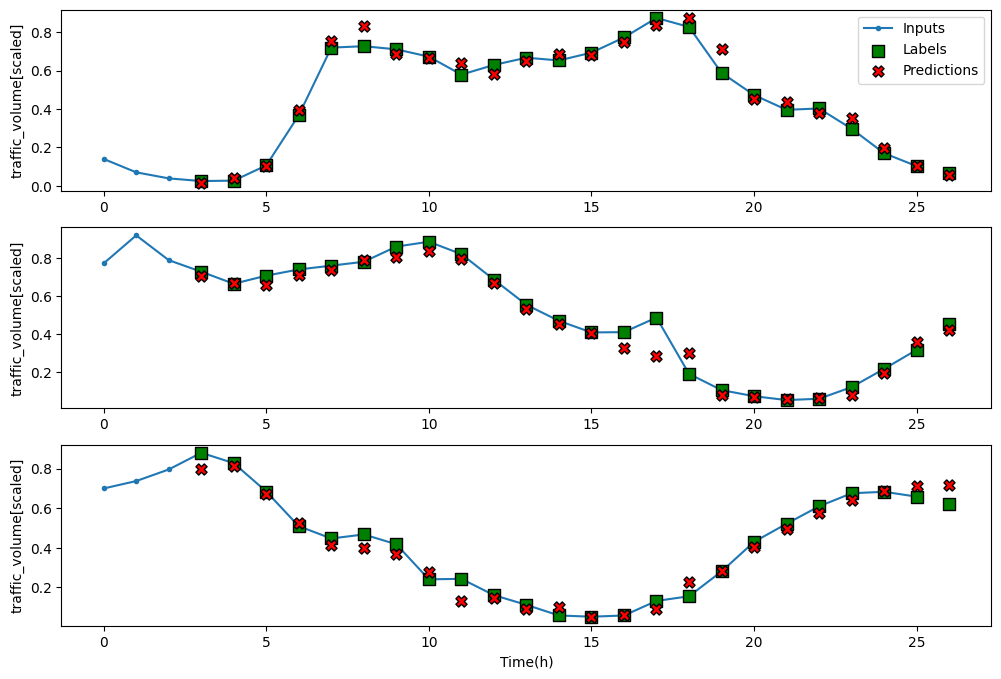

In [59]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
wide_conv_window.plot(model)

In [60]:
# モデルの訓練
model = CNNLSTMModel(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM_SINGLE,
    kernel_size=KERNEL_WIDTH,
    hidden_dim=HIDDEN_DIM
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.0307, Val Loss: 0.0070
Epoch 2/50, Train Loss: 0.0064, Val Loss: 0.0050
Epoch 3/50, Train Loss: 0.0049, Val Loss: 0.0039
Epoch 4/50, Train Loss: 0.0042, Val Loss: 0.0032
Epoch 5/50, Train Loss: 0.0037, Val Loss: 0.0029
Epoch 6/50, Train Loss: 0.0034, Val Loss: 0.0028
Epoch 7/50, Train Loss: 0.0032, Val Loss: 0.0027
Epoch 8/50, Train Loss: 0.0031, Val Loss: 0.0026
Epoch 9/50, Train Loss: 0.0030, Val Loss: 0.0025
Epoch 10/50, Train Loss: 0.0029, Val Loss: 0.0025
Epoch 11/50, Train Loss: 0.0029, Val Loss: 0.0024
Epoch 12/50, Train Loss: 0.0028, Val Loss: 0.0023
Epoch 13/50, Train Loss: 0.0028, Val Loss: 0.0024
Epoch 14/50, Train Loss: 0.0028, Val Loss: 0.0022
Epoch 15/50, Train Loss: 0.0028, Val Loss: 0.0025
Epoch 16/50, Train Loss: 0.0027, Val Loss: 0.0023
Epoch 17/50, Train Loss: 0.0027, Val Loss: 0.0023
Early stopping triggered


Validation MAE: 0.0366
Test MAE: 0.0330


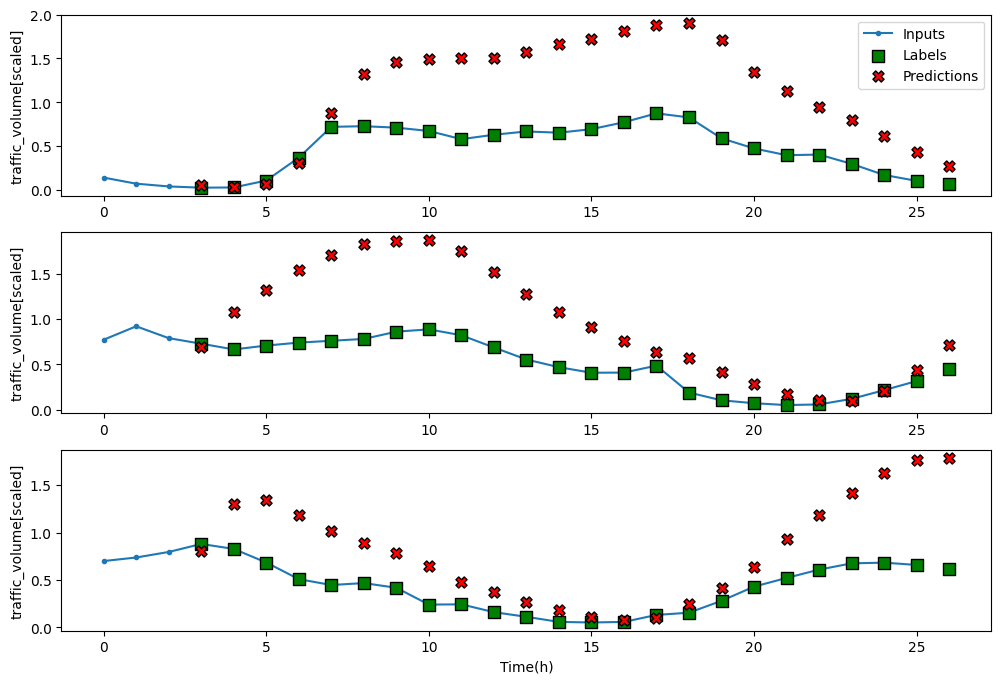

In [61]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
wide_conv_window.plot(model)

### 16.2.2 CNNをマルチステップモデルとして実装する

In [63]:
# マルチステップモデル用のデータウィンドウの作成（24時間分の入力から次の24時間の交通量を予測するモデル）
multi_window = DataWindow(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# dataloaderの作成
train_dataloader = multi_window.train
val_dataloader = multi_window.val
test_dataloader = multi_window.test

Epoch 1/50, Train Loss: 0.0270, Val Loss: 0.0165
Epoch 2/50, Train Loss: 0.0139, Val Loss: 0.0154
Epoch 3/50, Train Loss: 0.0135, Val Loss: 0.0152
Epoch 4/50, Train Loss: 0.0133, Val Loss: 0.0149
Epoch 5/50, Train Loss: 0.0132, Val Loss: 0.0146
Epoch 6/50, Train Loss: 0.0131, Val Loss: 0.0146
Epoch 7/50, Train Loss: 0.0129, Val Loss: 0.0145
Epoch 8/50, Train Loss: 0.0129, Val Loss: 0.0144
Epoch 9/50, Train Loss: 0.0128, Val Loss: 0.0158
Epoch 10/50, Train Loss: 0.0128, Val Loss: 0.0144
Epoch 11/50, Train Loss: 0.0128, Val Loss: 0.0144
Early stopping triggered
Validation MAE: 0.0788
Test MAE: 0.0643


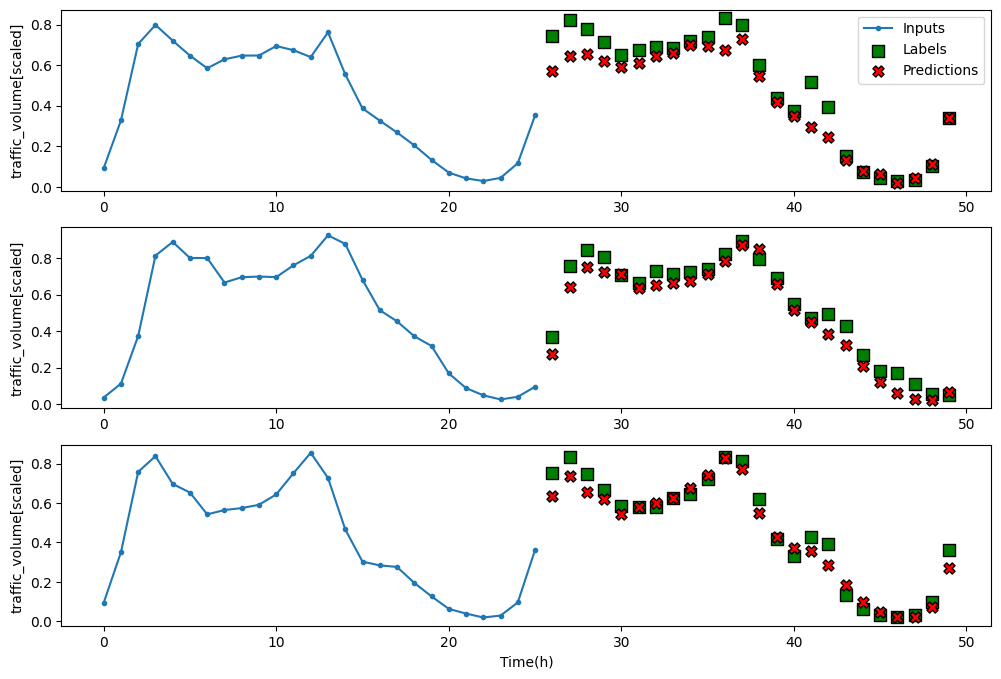

In [64]:
# モデルの訓練
model = CNNModel(
    input_dim=INPUT_DIM, 
        # 入力特徴量の次元は、チャネル数を表し、CNNを経て5→32へとなる次元のこと
        # 畳み込み演算は最終次元で行われるため、ここでの指定とは関係ない
    output_dim=OUTPUT_DIM_SINGLE,
    kernel_size=KERNEL_WIDTH
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
multi_window.plot(model)

Epoch 1/50, Train Loss: 0.0291, Val Loss: 0.0168
Epoch 2/50, Train Loss: 0.0144, Val Loss: 0.0161
Epoch 3/50, Train Loss: 0.0137, Val Loss: 0.0155
Epoch 4/50, Train Loss: 0.0131, Val Loss: 0.0162
Epoch 5/50, Train Loss: 0.0127, Val Loss: 0.0144
Epoch 6/50, Train Loss: 0.0124, Val Loss: 0.0145
Epoch 7/50, Train Loss: 0.0119, Val Loss: 0.0136
Epoch 8/50, Train Loss: 0.0113, Val Loss: 0.0133
Epoch 9/50, Train Loss: 0.0111, Val Loss: 0.0128
Epoch 10/50, Train Loss: 0.0107, Val Loss: 0.0131
Epoch 11/50, Train Loss: 0.0105, Val Loss: 0.0122
Epoch 12/50, Train Loss: 0.0103, Val Loss: 0.0120
Epoch 13/50, Train Loss: 0.0100, Val Loss: 0.0127
Epoch 14/50, Train Loss: 0.0099, Val Loss: 0.0116
Epoch 15/50, Train Loss: 0.0096, Val Loss: 0.0123
Epoch 16/50, Train Loss: 0.0095, Val Loss: 0.0118
Epoch 17/50, Train Loss: 0.0094, Val Loss: 0.0116
Epoch 18/50, Train Loss: 0.0093, Val Loss: 0.0112
Epoch 19/50, Train Loss: 0.0090, Val Loss: 0.0110
Epoch 20/50, Train Loss: 0.0090, Val Loss: 0.0110
Epoch 21/

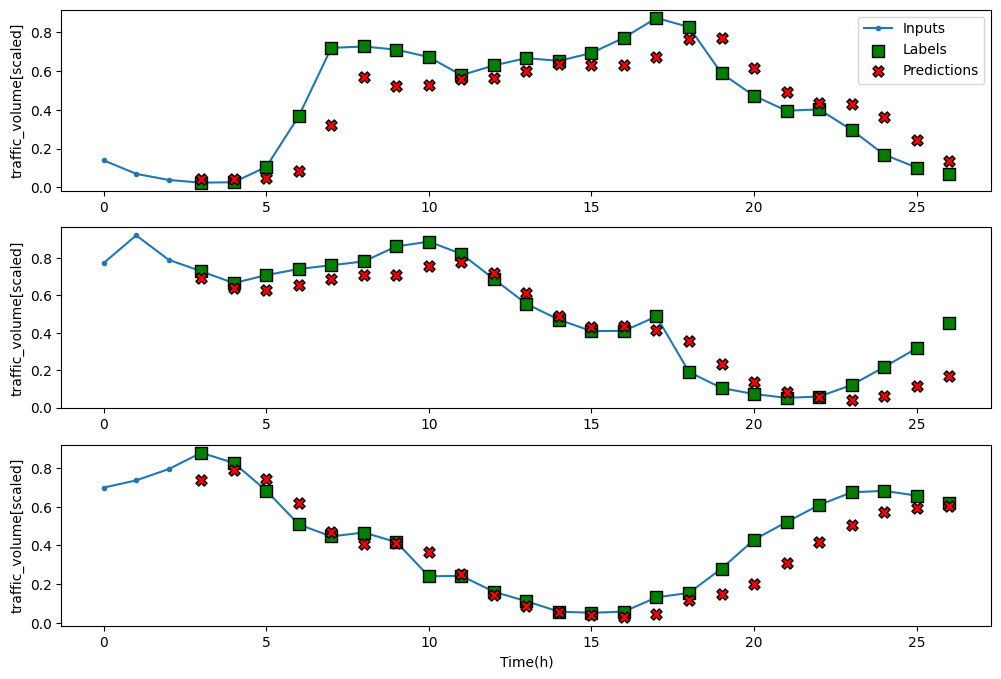

In [65]:
# モデルの訓練
model = CNNLSTMModel(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM_SINGLE,
    kernel_size=KERNEL_WIDTH,
    hidden_dim=HIDDEN_DIM
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
multi_window.plot(model)

### 16.2.3 CNNを多出力モデルとして実装する

In [69]:
# 多出力モデル用のデータウィンドウの作成
wide_mo_conv_window = DataWindow(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

# dataloaderの作成
train_dataloader = wide_mo_conv_window.train
val_dataloader = wide_mo_conv_window.val
test_dataloader = wide_mo_conv_window.test

Epoch 1/50, Train Loss: 0.0289, Val Loss: 0.0036
Epoch 2/50, Train Loss: 0.0032, Val Loss: 0.0024
Epoch 3/50, Train Loss: 0.0024, Val Loss: 0.0018
Epoch 4/50, Train Loss: 0.0020, Val Loss: 0.0016
Epoch 5/50, Train Loss: 0.0019, Val Loss: 0.0015
Epoch 6/50, Train Loss: 0.0018, Val Loss: 0.0014
Epoch 7/50, Train Loss: 0.0017, Val Loss: 0.0014
Epoch 8/50, Train Loss: 0.0017, Val Loss: 0.0013
Epoch 9/50, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 10/50, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 11/50, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 12/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 13/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 14/50, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 15/50, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 16/50, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 17/50, Train Loss: 0.0014, Val Loss: 0.0010
Epoch 18/50, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 19/50, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 20/50, Train Loss: 0.0013, Val Loss: 0.0010
Early sto

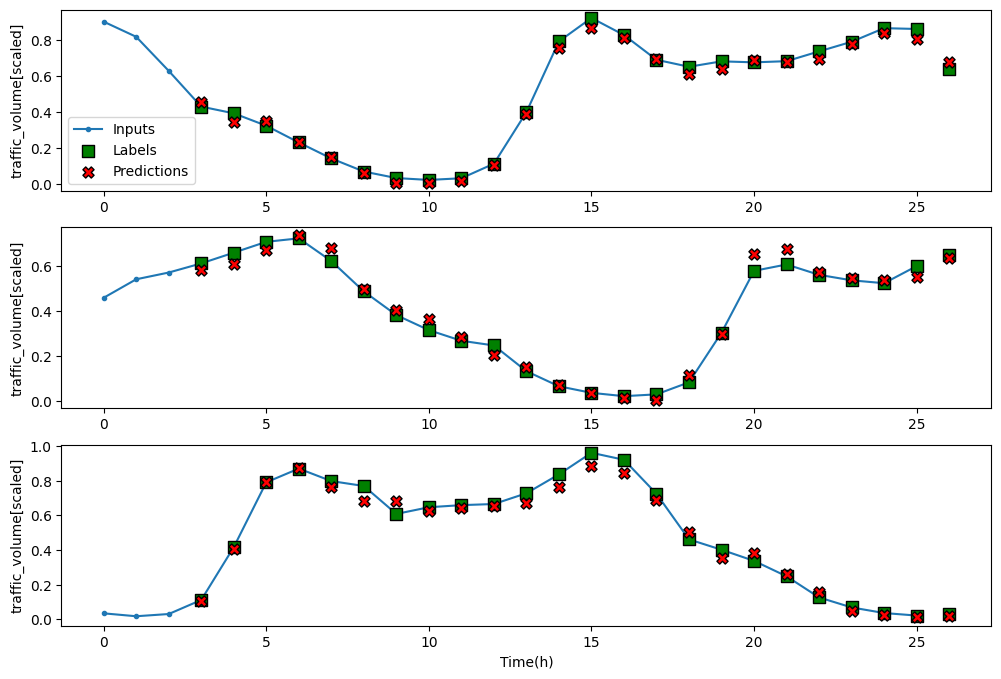

In [71]:
# モデルの訓練
model = CNNModel(
    input_dim=INPUT_DIM, 
        # 入力特徴量の次元は、チャネル数を表し、CNNを経て5→32へとなる次元のこと
        # 畳み込み演算は最終次元で行われるため、ここでの指定とは関係ない
    output_dim=OUTPUT_DIM_MULTI,
    kernel_size=KERNEL_WIDTH
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
wide_mo_conv_window.plot(model)

Epoch 1/50, Train Loss: 0.0175, Val Loss: 0.0031
Epoch 2/50, Train Loss: 0.0024, Val Loss: 0.0018
Epoch 3/50, Train Loss: 0.0020, Val Loss: 0.0017
Epoch 4/50, Train Loss: 0.0018, Val Loss: 0.0015
Epoch 5/50, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 6/50, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 7/50, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 8/50, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 9/50, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 10/50, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 11/50, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 12/50, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 13/50, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 14/50, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 15/50, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 16/50, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 17/50, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 18/50, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 19/50, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 20/50, Train Loss: 0.0011, Val Loss: 0.0009
Early sto

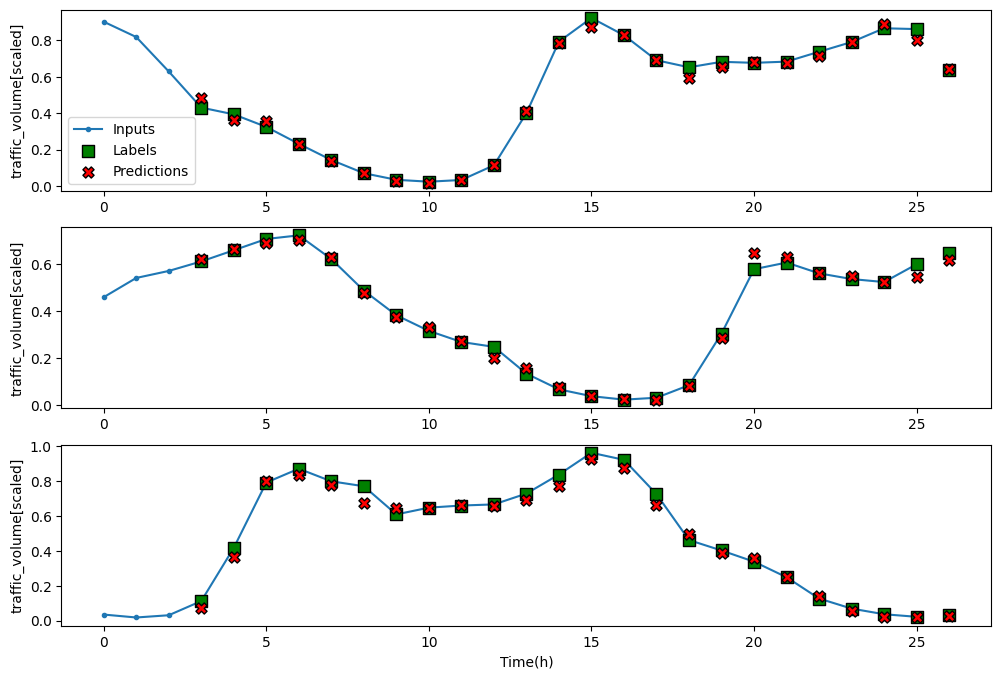

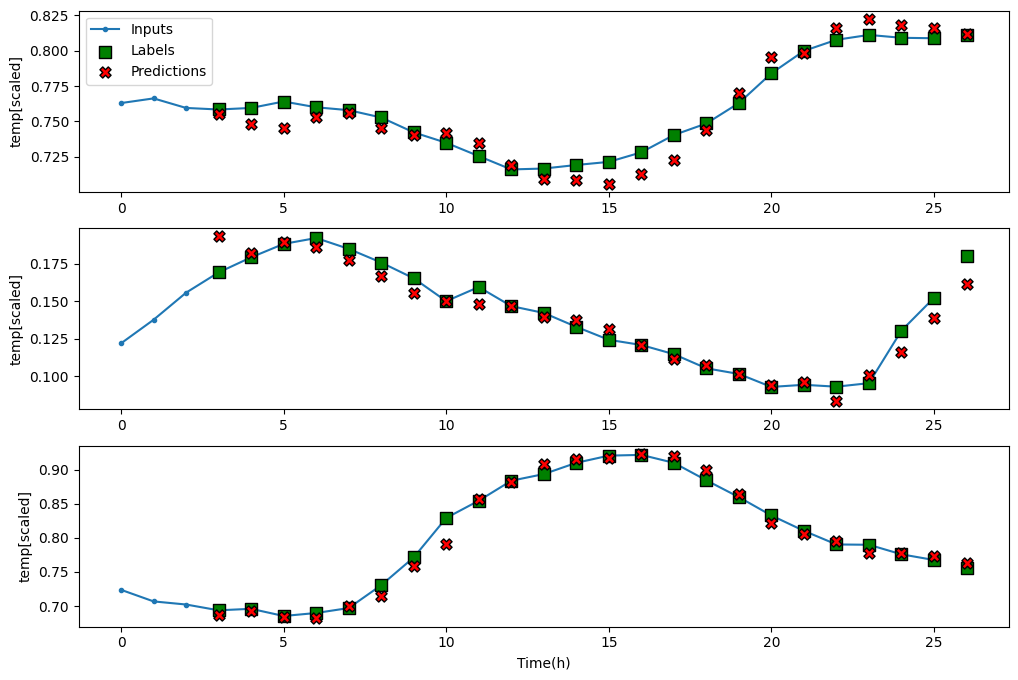

In [72]:
# モデルの訓練
model = CNNLSTMModel(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM_MULTI,
    kernel_size=KERNEL_WIDTH,
    hidden_dim=HIDDEN_DIM
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
wide_mo_conv_window.plot(model)
wide_mo_conv_window.plot(model, plot_col='temp')